In [2]:
import os
import sys
from tqdm import tqdm
import numpy as np

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

print(os.getcwd())

import torch
import torch.nn as nn
import torchvision.transforms as T
from model.resnet_enc_dec_model import ResNetEncDec
from datasets_utils.dataset_class import DynamicMVTecDataset
from datasets_utils.dataset_split import split_dataset
from datasets_utils.dataset_transform import get_transforms
from torch.utils.data import DataLoader
import matplotlib.pylab as plt
import random
from torch.utils.data import Dataset
from PIL import Image

device = "cuda" if torch.cuda.is_available() else "cpu"

/home/sameerhashmi36/Documents/AVS7/anomaly_detection_computer_vision/mvtec_anomaly_detection_scipt/testing


In [2]:
# Data transform
transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

In [3]:
dataset = DynamicMVTecDataset(good_image_dir="../../datasets/mvtec/bottle/train/good/", transform=transform, augmentations=['cutpaste'])
_, val_data = split_dataset(dataset=dataset)

In [4]:
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, num_workers=4)

In [5]:

def load_trained_model(checkpoint_path, device):
    """
    Load the trained model from a checkpoint.

    Parameters:
    - checkpoint_path: Path to the saved model checkpoint.
    - device: The device to map the model to.

    Returns:
    - model: The trained model in evaluation mode.
    """
    model = ResNetEncDec().to(device)
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # Set the model to evaluation mode
    return model

In [6]:
def test_model(model, test_loader, criterion, device):
    """
    Evaluate the model on a test dataset.

    Parameters:
    - model: The trained model.
    - test_loader: DataLoader for the test dataset.
    - criterion: Loss function (e.g., BCE loss).
    - device: The device to perform evaluation on.

    Returns:
    - avg_loss: Average test loss.
    """
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, masks, labels in tqdm(test_loader, desc="Testing"):
            images, masks = images.to(device), masks.to(device)

            # Forward pass
            decoded, _ = model(images)
            decoded = torch.sigmoid(decoded)

            # Compute loss
            loss = criterion(decoded, masks)
            total_loss += loss.item()
    
    avg_loss = total_loss / len(test_loader)
    print(f"Average Test Loss: {avg_loss:.4f}")
    return avg_loss

In [7]:
def visualize_samples(model, test_loader, device, num_samples=10):
    """
    Visualize random samples from the test dataset with predictions and ground truth masks.

    Parameters:
    - model: The trained model.
    - test_loader: DataLoader for the test dataset.
    - device: The device to perform inference on.
    - num_samples: Number of samples to visualize.
    """
    model.eval()
    samples = random.sample(list(test_loader), num_samples)
    # samples_count = 0

    for images, masks, labels in samples:
        images, masks = images.to(device), masks.to(device)

        # Forward pass
        with torch.no_grad():
            decoded, _ = model(images)
            decoded = torch.sigmoid(decoded)

        # Convert tensors to numpy arrays
        images = images.cpu().permute(0, 2, 3, 1).numpy()  # Rearrange dimensions for visualization
        decoded = decoded.cpu().squeeze(1).numpy()
        masks = masks.cpu().squeeze(1).numpy()

        # Plot images, predictions, and masks
        for i in range(len(images)):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 3, 1)
            plt.imshow(images[i], cmap='gray')
            plt.title("Input Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(decoded[i], cmap='gray')
            plt.title("Predicted Mask")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(masks[i], cmap='gray')
            plt.title("Ground Truth Mask")
            plt.axis("off")

            plt.tight_layout()
            plt.show()

            # samples_count += 1
            # if samples_count >= num_samples:
            #     return


In [9]:
# Load trained model
checkpoint_path = "../experiments/experiment_01_bottle_cutpaste/checkpoints/model_epoch_49_valloss_0.0613.pth"
model = load_trained_model(checkpoint_path, device)

In [10]:
# Criterion for loss calculation
criterion = nn.BCELoss()

In [11]:
# Test the model
test_model(model, val_loader, criterion, device)

Testing: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

Average Test Loss: 0.0611


0.061131373047828674

In [ ]:

# Visualize random samples
visualize_samples(model, val_loader, device, num_samples=1)

In [14]:
class TestingMVTecDataset(Dataset):
    def __init__(self, test_dir, ground_truth_dir, transform=None):
        """
        Custom dataset for testing MVTec data.

        Parameters:
        - test_dir: Path to the test images folder.
        - ground_truth_dir: Path to the ground truth masks folder.
        - transform: Transformations to apply to the test images.
        """
        self.test_dir = test_dir
        self.ground_truth_dir = ground_truth_dir
        self.transform = transform
        self.data = []

        # Iterate through all subfolders (broken_large, broken_small, contamination)
        for subfolder in os.listdir(test_dir):
            test_subfolder = os.path.join(test_dir, subfolder)
            gt_subfolder = os.path.join(ground_truth_dir, subfolder)

            if os.path.isdir(test_subfolder) and os.path.isdir(gt_subfolder):
                for img_file in os.listdir(test_subfolder):
                    if img_file.endswith(".png"):
                        test_img_path = os.path.join(test_subfolder, img_file)
                        gt_mask_path = os.path.join(gt_subfolder, img_file.replace(".png", "_mask.png"))
                        
                        # Only add entries where both test image and ground truth mask exist
                        if os.path.isfile(test_img_path) and os.path.isfile(gt_mask_path):
                            self.data.append((test_img_path, gt_mask_path))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        test_img_path, gt_mask_path = self.data[idx]

        # Load test image
        test_image = Image.open(test_img_path).convert("RGB")

        # Load ground truth mask
        ground_truth_mask = Image.open(gt_mask_path).convert("L")  # Grayscale for mask

        # Apply transformations
        if self.transform:
            test_image = self.transform(test_image)
            ground_truth_mask = self.transform(ground_truth_mask)

        return test_image, ground_truth_mask, test_img_path


In [15]:
test_image_dir = "../../datasets/mvtec/bottle/test/"
ground_truth_dir = "../../datasets/mvtec/bottle/ground_truth"

test_dataset = TestingMVTecDataset(test_dir=test_image_dir, ground_truth_dir=ground_truth_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

print(f"Number of test samples: {len(test_dataset)}")

Number of test samples: 63


In [16]:
# Test the model
test_model(model, test_loader, criterion, device)

Testing: 100%|██████████| 63/63 [00:03<00:00, 16.62it/s]

Average Test Loss: 0.1521


0.15212009066627138

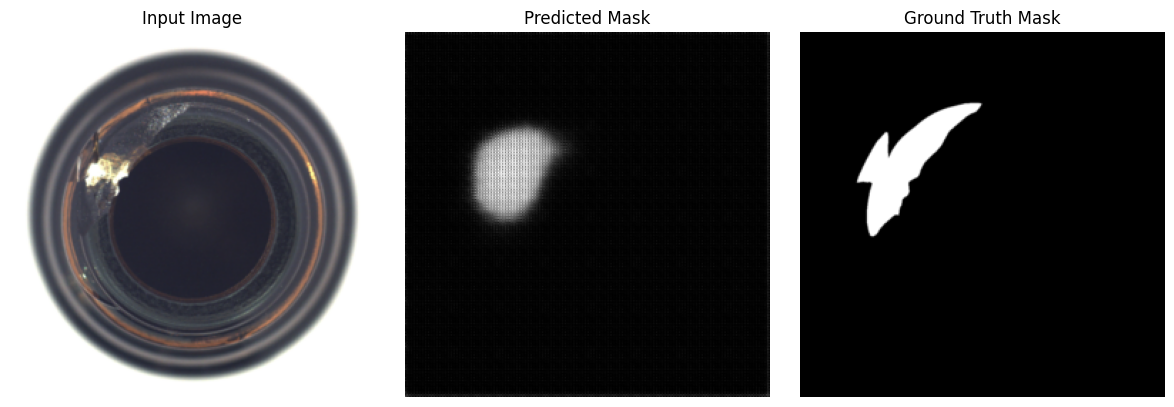

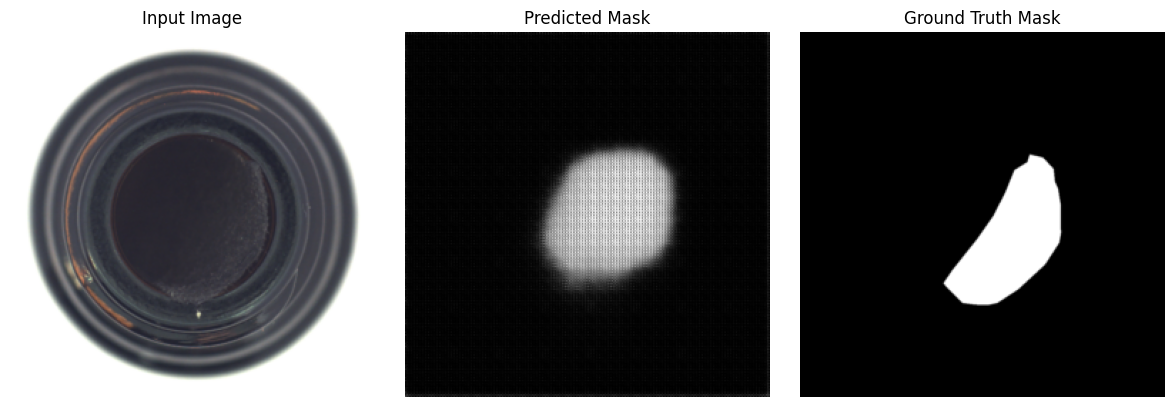

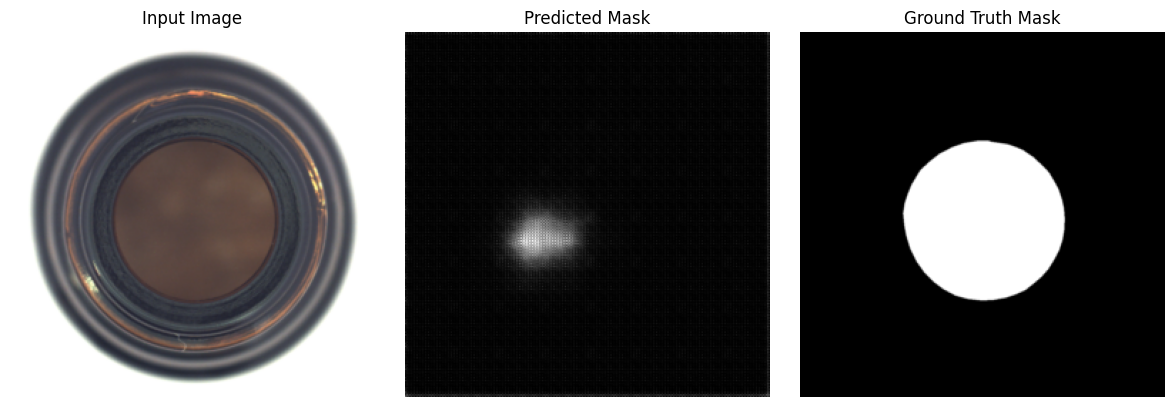

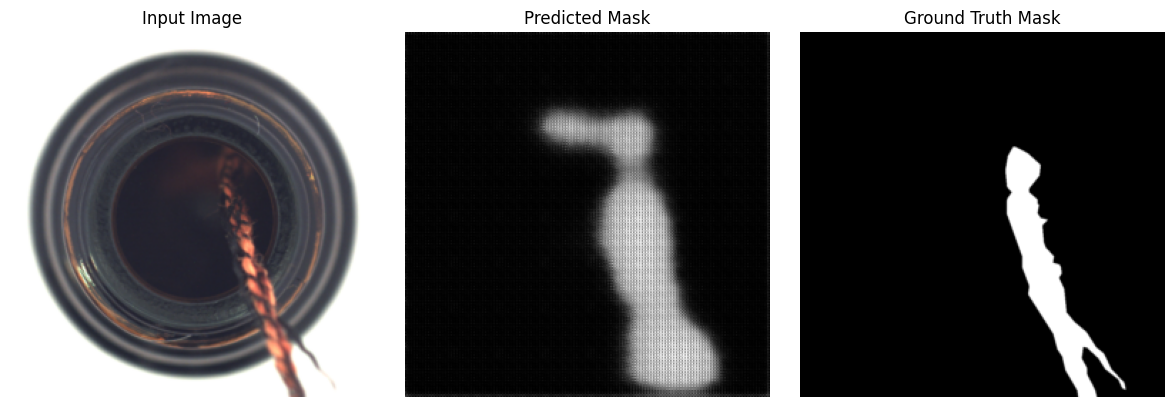

In [17]:
# Visualize random samples
visualize_samples(model, test_loader, device, num_samples=4)

In [22]:
from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve

In [23]:
# def calculate_threshold(model, normal_loader, device):
#     """
#     Calculate the white pixel threshold using Gaussian distribution or max pixel value.
#     """
#     model.eval()
#     white_pixel_ratios = []

#     with torch.no_grad():
#         for images, masks, labels in tqdm(normal_loader, desc="Calculating Threshold"):
#             images = images.to(device)

#             # Forward pass
#             decoded, _ = model(images)
#             decoded = torch.sigmoid(decoded)

#             # Convert the mask to binary and count white pixels
#             binary_mask = (decoded > 0.5).float()
#             white_pixel_ratio = binary_mask.mean().item()
#             white_pixel_ratios.append(white_pixel_ratio)

#     # Use Gaussian distribution to calculate threshold
#     white_pixel_ratios = np.array(white_pixel_ratios)
#     mean = np.mean(white_pixel_ratios)
#     std = np.std(white_pixel_ratios)
#     threshold = mean + 3 * std  # Set threshold to 3 standard deviations above the mean
#     print(f"Threshold (Gaussian): {threshold:.4f}")

#     return threshold


In [27]:
def test_model_and_evaluate(model, test_loader, device):
    """
    Evaluate the model on test data and calculate AUROC and confusion matrix.
    """
    model.eval()
    y_true = []  # Ground truth labels
    y_scores = []  # Predicted scores (white pixel ratios)

    with torch.no_grad():
        for images, masks, labels in tqdm(test_loader, desc="Testing"):
            images = images.to(device)
            masks = masks.to(device)

            # Forward pass
            decoded, _ = model(images)
            decoded = torch.sigmoid(decoded)

            # Convert predicted mask to binary and calculate white pixel ratio
            binary_mask = (decoded > 0.5).float()
            white_pixel_ratios = binary_mask.mean(dim=(1, 2, 3)).cpu().tolist()  # Mean white pixels per image

            y_true.extend(labels.cpu().tolist())  # Append all labels in the batch
            y_scores.extend(white_pixel_ratios)  # Append white pixel ratios for all images in the batch

    # Calculate AUROC
    auc_score = roc_auc_score(y_true, y_scores)
    print(f"AUROC: {auc_score:.4f}")

    # Calculate confusion matrix
    # y_pred = [1 if score > threshold else 0 for score in y_scores]
    # cm = confusion_matrix(y_true, y_pred)
    # print("Confusion Matrix:")
    # print(cm)

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_scores)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {auc_score:.4f})")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

    return auc_score  #, cm


In [28]:
# Calculate threshold using normal samples
normal_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
# threshold = calculate_threshold(model, normal_loader, device)

Testing: 100%|██████████| 4/4 [00:03<00:00,  1.00it/s]


AUROC: 0.9792


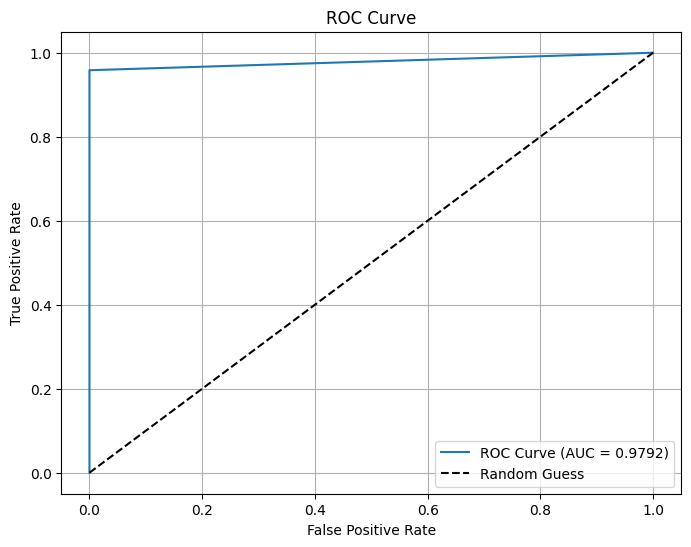

In [30]:
auc_score = test_model_and_evaluate(model, val_loader, device)